In [18]:
import cv2
import os
import datetime
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.layers import Flatten, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from math import sin, cos, radians
from keras.models import load_model

In [19]:
# Hyperparameters
IMAGE_SIZE = 224
CHANNELS = 3

In [20]:
# Load dataset to memory:
images_folder = 'C:\\Users\\VAMSIDHAR S\\Downloads\\Dataset'
model_folder = ""
labels = []
images = []

def resize(img, target):
    """ Resize an image """
    resized = cv2.resize(img, (target, target),
                         interpolation = cv2.INTER_AREA).astype(np.float32)
    return resized.reshape((-1))

for folder in os.listdir(images_folder):
    if folder in ('with_mask','without_mask'):
        for filename in os.listdir(os.path.join(images_folder,folder)):
            labels.append(folder)
            img = cv2.imread(os.path.join(images_folder,folder,filename))
            images.append(resize(img, IMAGE_SIZE))
            
images = np.array(images)
labels = pd.get_dummies(labels).to_numpy()

In [21]:
# Data partitioning
x_train, x_test, y_train, y_test = train_test_split(
    images.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    labels, train_size=0.7, stratify=labels, random_state=42)

In [22]:
def display_images(df):
    df = np.array(df)
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(np.arange(len(df)),
                               9, replace=False)
    images = df[indices]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[i].reshape((224,224,3))
                                .astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.axis("off")

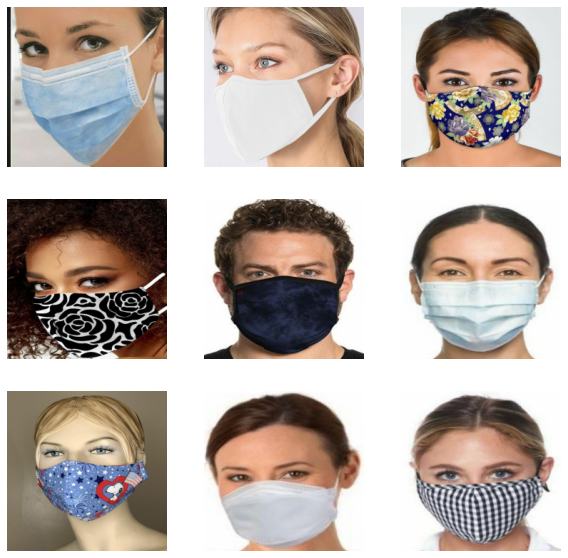

In [23]:
display_images(x_train[y_train[:,0]==1])

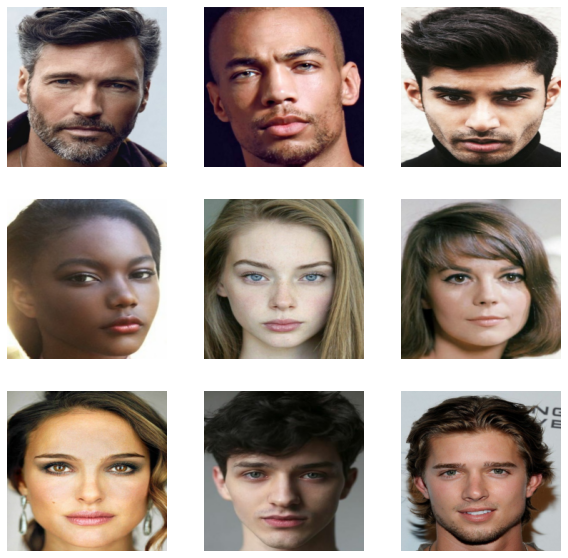

In [24]:
display_images(x_train[y_train[:,1]==1])

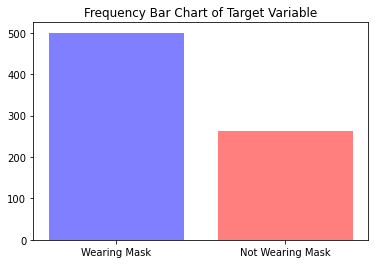

In [25]:
mask_counts = np.sum(labels[:,0], axis=0)
non_mask_counts = np.sum(labels[:, 1], axis=0)
plt.figure()
plt.title("Frequency Bar Chart of Target Variable")
plt.bar(['Wearing Mask','Not Wearing Mask'],
        [mask_counts,non_mask_counts], color=['blue','red'],
        align='center', alpha=0.5)
plt.show()

In [26]:
# Auxiliary augmentation function

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*np.random.rand()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Generating augmentations
trdata = ImageDataGenerator(rescale=1./255, rotation_range=40,
                            width_shift_range=0.2, height_shift_range=0.2,
                            horizontal_flip=True, channel_shift_range=50,
                            preprocessing_function = add_noise)
traindata = trdata.flow(x_train, y_train)

tsdata = ImageDataGenerator(rescale=1./255, rotation_range=40,
                            width_shift_range=0.2, height_shift_range=0.2,
                            horizontal_flip=True, channel_shift_range=50,
                            preprocessing_function = add_noise)
testdata = tsdata.flow(x_test, y_test)
# Load VGG19 architecture as transfer learning model
vgg = VGG19(weights='imagenet', include_top=False,
            input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
vgg.trainable = False
flatten = Flatten()(vgg.output)
d1 = Dense(2, activation="softmax")(flatten)
model = Model(inputs=vgg.input, outputs=d1)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [27]:
# Handling imbalanced data
class_weight = {0: 1., 1: 2.}

In [28]:
opt = Adam(learning_rate = 1e-5)
model.compile(optimizer=opt,
              loss=categorical_crossentropy, metrics=['accuracy'])
early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0, verbose=1, patience=5, mode='auto')
hist = model.fit(traindata, steps_per_epoch=10, 
                 verbose=2, validation_data=testdata, validation_steps=5,
                 epochs=70, callbacks=[early], shuffle=True,
                 class_weight=class_weight)

Epoch 1/70
10/10 - 17s - loss: 0.9653 - accuracy: 0.6469 - val_loss: 0.6629 - val_accuracy: 0.5750
Epoch 2/70
10/10 - 13s - loss: 0.8985 - accuracy: 0.6031 - val_loss: 0.6578 - val_accuracy: 0.6000
Epoch 3/70
10/10 - 13s - loss: 0.8818 - accuracy: 0.5728 - val_loss: 0.6851 - val_accuracy: 0.5312
Epoch 4/70
10/10 - 12s - loss: 0.8282 - accuracy: 0.6313 - val_loss: 0.6354 - val_accuracy: 0.6438
Epoch 5/70
10/10 - 12s - loss: 0.8495 - accuracy: 0.6958 - val_loss: 0.6094 - val_accuracy: 0.6562
Epoch 6/70
10/10 - 12s - loss: 0.7739 - accuracy: 0.7282 - val_loss: 0.5890 - val_accuracy: 0.7437
Epoch 7/70
10/10 - 12s - loss: 0.7515 - accuracy: 0.7344 - val_loss: 0.5728 - val_accuracy: 0.6938
Epoch 8/70
10/10 - 11s - loss: 0.7252 - accuracy: 0.7702 - val_loss: 0.5481 - val_accuracy: 0.7812
Epoch 9/70
10/10 - 12s - loss: 0.6986 - accuracy: 0.8062 - val_loss: 0.5124 - val_accuracy: 0.8000
Epoch 10/70
10/10 - 12s - loss: 0.6711 - accuracy: 0.8062 - val_loss: 0.5223 - val_accuracy: 0.7937
Epoch 11/

In [29]:
video_file = "C:\\Users\\VAMSIDHAR S\\Downloads\\handkerchief.mp4"

In [30]:
from yoloface import face_analysis

In [31]:
# Hyperparameters for face alignment routine
settings = {
    'scaleFactor': 1.3,
    'minNeighbors': 3,
    'minSize': (50, 50),
    'flags': cv2.CASCADE_SCALE_IMAGE
}

def rotate_image(image, angle):
    """ Rotate an image by a given rotation angle """
    if angle == 0: return image
    height, width = image.shape[:2]
    rot_mat = cv2.getRotationMatrix2D((width/2,
                                       height/2), angle, 0.9)
    result = cv2.warpAffine(image, rot_mat, (width, height),
                            flags=cv2.INTER_LINEAR)
    return result
def rotate_point(pos, img, angle):
    """
    Compute the position of the detected faces in the
    original image (undo the rotation)
    """
    if angle == 0: return pos
    x = pos[0]-img.shape[1]*0.4
    y = pos[1]-img.shape[0]*0.4
    newx = x*cos(radians(angle)) + y*sin(radians(angle)) + img.shape[1]*0.4
    newy = -x*sin(radians(angle)) + y*cos(radians(angle)) + img.shape[0]*0.4
    return int(newx), int(newy), pos[2], pos[3]

In [32]:
# Opens the Video file
cap = cv2.VideoCapture(os.path.join(images_folder, video_file))
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# Get the frame width, height and fps
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
# Define output video file
out = cv2.VideoWriter('Output.avi',
                      fourcc, 20.0, (frame_width, frame_height), isColor=True)
face = cv2.CascadeClassifier(cv2.data.haarcascades+ 'haarcascade_frontalface_default.xml')
cv2.destroyAllWindows()
# Load Yoloface object
yoloface_model = face_analysis()

yolov3-tiny_face.weights:: status : file already exists
yolov3_tiny_face.cfg:: status : file already exists
face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists


In [33]:
model.save("yolofacemodel.h5")
loaded_model = load_model("yolofacemodel.h5")

In [34]:
# Loop over each frame
i = 0
t_start = time.time()
print("Video processing started...")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        t_end = time.time()
        print("Video processing done.")
        print("Video duration of", i / fps,
              "seconds was successfully processed in",
              (round(t_end - t_start, 2)), "seconds.")
        break
    # Detect faces in the image
    img, boxes, _ = yoloface_model.face_detection(frame_arr=frame, model='tiny')
    # Loop over each face found by Yoloface
    for box in boxes:
        # Extract the bounding boxes for each face and manually adjusting boundaries
        x1, y1, width, height = box
        x2, y2 = x1 + width - 10, y1 + height + 50
        y1 = 0 if y1 < 0 else y1
        x1 = 0 if x1 < 0 else x1
        img = cv2.resize(frame[y1:y2, x1:x2], (IMAGE_SIZE, IMAGE_SIZE),
                         interpolation=cv2.INTER_AREA).astype('uint8')
        # Aligning face
        for angle in [0, -25, 25]:
            rimg = rotate_image(frame[y1:y2, x1:x2], angle)
            detected = face.detectMultiScale(rimg, **settings)
            if len(detected):
                detected = [rotate_point(detected[-1], frame, -angle)]
                break
        # Predicting if a person is wearing mask (0) or not (1) with c.l. > 70%
        pred = model.predict(resize(img,IMAGE_SIZE).reshape(1, IMAGE_SIZE,
                                                            IMAGE_SIZE, CHANNELS))
        mask_result = np.argmax(pred)
        confidence = pred[0][mask_result] * 100
        # Plot bounding box as well as confidence level (model's output)
        if mask_result == 1 and confidence > 0.7:
            text = "Not Wearing Mask, Conf: {0:.2f}%".format(confidence)
            cv2.rectangle(frame, (x1, y1), (x2+10, y2+10), (0, 0, 255), 2)
            cv2.putText(frame, text, (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        if mask_result == 0 and confidence > 0.7:
            text = "Wearing Mask, Conf: {0:.2f}%".format(confidence)
            cv2.rectangle(frame, (x1, y1), (x2+10, y2+10), (0, 255, 0), 2)
            cv2.putText(frame, text, (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    i += 1
    # Write the frame
    out.write(frame)
# Release everything if job is finished
cap.release()
out.release()

Video processing started...
Video processing done.
Video duration of 4.933333333333334 seconds was successfully processed in 30.42 seconds.
